# Depth findings in Books

## Retrieve places and dates to put books in historical contexts

### Importing Data

Importing relevant packages:

In [1]:
import re
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df_books_reviews = pd.read_csv('../Data/processed/books/sentiment_patterns_books_reviews.csv', index_col=False)

In [3]:
df_books_reviews.rename(columns = {'Unnamed: 0': 'counter'}, inplace=True)

In [4]:
df_books_reviews.head(3)

,counter,book_id,has_spoiler,rating,review_id,review_sentences,timestamp,user_id,title,description,text_normalized,polarity_textBlob,subjectivity_textBlob,sentiment_scores,sentiment_category
0,0,16981,False,3,a5d2c3628987712d0e05c4f90798eb67,"[[0, 'Recommended by Don Katz.'], [0, 'Avail f...",2017-03-22,8842281e1d1347389f2ab93d60773d4d,Invisible Man,First published in 1952 and immediately hailed...,recommended by don katz avail for free in dece...,0.4000,0.8000,3.0,positive
1,1,16981,False,4,706a8032efbde550167bf0d96c2ab501,"[[0, 'This book was actually good, so long tho...",2015-02-25,2159f55d397e8fbe68d5e03668e7d9d2,Invisible Man,First published in 1952 and immediately hailed...,this book wa actually good so long though haha...,0.4125,0.5125,9.0,positive
2,2,16981,False,3,f72cb35f64a70beeda185dd744782b53,"[[0, 'Immensely complicated look at the many f...",2014-03-09,22b29f4e3b4b679ac9abb2c09f9a940e,Invisible Man,First published in 1952 and immediately hailed...,immensely complicated look at the many facet o...,-0.2500,0.5250,-5.0,negative


In [5]:
df_books = pd.read_csv('../Data/processed/books/books_noDict_year.csv', index_col=False)

In [6]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581450 entries, 0 to 581449
Data columns (total 32 columns):
Unnamed: 0              581450 non-null int64
asin                    41515 non-null object
authors                 581450 non-null object
average_rating          581450 non-null float64
book_id                 581450 non-null int64
country_code            581450 non-null object
description             581450 non-null object
edition_information     68270 non-null object
format                  559346 non-null object
image_url               581450 non-null object
is_ebook                581450 non-null bool
isbn                    413393 non-null object
isbn13                  475271 non-null object
kindle_asin             242123 non-null object
language_code           355032 non-null object
link                    581450 non-null object
num_pages               581450 non-null float64
popular_shelves         581450 non-null object
publication_day         452057 non-null float64

In [7]:
df_books_col = df_books.loc[:, ['book_id', 'title', 'language_code', 
                  'description', 'similar_books', 'average_rating', 'ratings_count',
                  'num_pages', 'text_reviews_count']]

In [8]:
df_books_col.head()

,book_id,title,language_code,description,similar_books,average_rating,ratings_count,num_pages,text_reviews_count
0,7327624,"The Unschooled Wizard (Sun Wolf and Starhawk, ...",eng,Omnibus book club edition containing the Ladie...,"['19997', '828466', '1569323', '425389', '1176...",4.03,140.0,600.0,7.0
1,287141,The Aeneid for Boys and Girls,NaN,"Relates in vigorous prose the tale of Aeneas, ...",[],4.13,46.0,162.0,7.0
2,6066812,All's Fairy in Love and War (Avalon: Web of Ma...,NaN,"To Kara's astonishment, she discovers that a p...","['948696', '439885', '274955', '12978730', '37...",4.22,98.0,216.0,6.0
3,287149,The Devil's Notebook,NaN,"Wisdom, humor, and dark observations by the fo...","['287151', '1104760', '1172822', '440292', '28...",3.81,986.0,147.0,39.0
4,6066814,"Crowner Royal (Crowner John Mystery, #13)",NaN,"London, 1196. At the command of Richard the Li...","['439108', '522621', '116770', '1275927', '620...",3.93,186.0,400.0,15.0


In [9]:
english_list = ['eng', 'en-US', 'en-GB', 'en-CA', 'en', 'en-IN']

In [10]:
df_books_col_eng = df_books_col[df_books_col.language_code.isin(english_list)]

In [11]:
try:
    assert len(df_books_col.books_id) == len(df_books_col.books_id.unique())
except:
    df_books_col.drop_duplicates('book_id', keep='first', inplace=True)

Selecting index to analyse tags:

In [17]:
ind = [19, 39, 57, 59, 76, 95, 102, 114, 120, 126, 136, 
       150, 192, 194, 247, 282, 283, 288, 295, 331, 367,
       401, 414, 423, 442, 451, 465, 2554, 2556, 2575, 
       2598, 2603, 2630, 2671, 2673, 2713, 2716, 2717,
       2761, 2786, 2836, 2925, 2930, 2961, 2968, 3050]

In [19]:
df_sample_PoS = df_books_col_eng.loc[ind, :]

In [37]:
df_sample_PoS.head()

,book_id,title,language_code,description,similar_books,average_rating,ratings_count,num_pages,text_reviews_count
19,13598461,Labor and Desire: Women's Revolutionary Fictio...,eng,"""This critical, historical, and theoretical st...",[],4.00,2.0,236.0,1.0
39,780911,The Crimson Petal and the White,eng,"""Michel Faber leads us back to 1870s London, w...","['1153738', '1038223', '92286', '10387214', '4...",3.87,681.0,838.0,94.0
57,17368265,"White Fire (Pendergast, #13)",eng,Past and present collide as Special Agent Pend...,"['11007668', '16065538', '15841850', '13539179...",4.07,250.0,13.0,46.0
59,27036536,"War Stories, Volume 3",eng,PRODUCT DESCRIPTION: The first new volume of G...,[],4.15,39.0,224.0,9.0
76,16250763,One Gay American,eng,Dennis Milam Bensie is One Gay American. Born ...,"['13203056', '16110535', '16047746', '15818296...",3.90,17.0,242.0,7.0


Importing spacy and the model `en_core_web_sm`

In [20]:
import sys
!{sys.executable} -m spacy download en_core_web_sm
#! python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [21]:
import spacy
from spacy.lang.en import English
from spacy import displacy
from collections import Counter
import en_core_web_sm
nlp = en_core_web_sm.load()

In [39]:
for i in df_sample_PoS.index:
    doc = nlp(df_sample_PoS.description[i])
    print(df_sample_PoS.title[i])
    print([(X.text, X.label_) for X in doc.ents])
    displacy.render(nlp(text), jupyter=True, style='ent')

Labor and Desire: Women's Revolutionary Fiction in Depression America
[('the 1930s', 'DATE'), ('Paula Rabinowitz', 'PERSON'), ('the decade', 'DATE'), ('Amazon', 'ORG')]


The Crimson Petal and the White
[('Michel Faber', 'ORG'), ('1870s', 'DATE'), ('London', 'GPE'), ('Sugar', 'ORG'), ('nineteen-year-old', 'DATE'), ('Castaway', 'PERSON'), ('Victorian Society', 'ORG'), ('William Rackham', 'PERSON'), ('Sugar', 'PERSON'), ('Agnes', 'GPE'), ('Sophie', 'PERSON'), ('Henry', 'PERSON'), ('the Widow Fox', 'FAC'), ('The Rescue Society', 'ORG'), ('Henry', 'PERSON')]


White Fire (Pendergast, #13)
[('Special Agent Pendergast', 'ORG'), ('19th century', 'DATE'), ('Colorado', 'GPE'), ('Sherlock Holmes', 'PERSON'), ('1876', 'DATE'), ('Roaring Fork', 'ORG'), ('the Colorado Rockies', 'FAC'), ('eleven', 'CARDINAL'), ('Corrie Swanson', 'PERSON'), ('FBI', 'ORG'), ('multimillion-dollar', 'MONEY'), ('Pendergast', 'ORG'), ('Sherlock Holmes', 'PERSON'), ('Corrie', 'PERSON')]


War Stories, Volume 3
[('first', 'ORDINAL'), ('Garth Ennis', 'FAC'), ('War Stories', 'LOC'), ('three', 'CARDINAL'), ('Ennis', 'ORG'), ('Tomas Aira', 'PERSON'), ('Sky', 'FAC'), ('Germany', 'GPE'), ('Israel', 'GPE'), ('1973', 'DATE'), ('the Golan Heights', 'LOC'), ('Israel', 'GPE'), ('Syrian', 'NORP'), ('February 1945', 'DATE'), ('Soviet', 'NORP'), ('Germany', 'GPE'), ('War Stories', 'LOC')]


One Gay American
[('Dennis Milam Bensie', 'PERSON'), ('One', 'CARDINAL'), ('Gay American', 'NORP'), ('the 1960s', 'DATE'), ('Robinson', 'GPE'), ('Illinois', 'GPE'), ('Bensie', 'ORG'), ('nineteen years old', 'DATE'), ('a Cabbage Patch Doll', 'WORK_OF_ART'), ('a Cabbage Patch Doll', 'WORK_OF_ART'), ('Bensie', 'ORG'), ('Bensie', 'ORG'), ('Bensie', 'ORG'), ('One', 'CARDINAL'), ('Gay American', 'NORP'), ('decade', 'DATE'), ('decade', 'DATE'), ('Bensie', 'ORG')]


Fire and Sword
[('Daniel Rawson', 'PERSON'), ('French', 'NORP'), ('Daniel', 'PERSON'), ('English', 'NORP'), ('Daniel', 'PERSON'), ('England', 'GPE'), ('French', 'NORP'), ('the Duc de Vendome', 'ORG'), ('Daniel', 'PERSON'), ('REVIEWS', 'ORG'), ('Fire and Sword', 'WORK_OF_ART'), ('Daniel Rawson', 'PERSON'), ('French', 'NORP'), ('early eighteenth century', 'DATE'), ('Europe', 'LOC'), ('French', 'NORP'), ('Rawson', 'ORG'), ('Fire and Sword', 'WORK_OF_ART'), ('Book Review', 'WORK_OF_ART')]


Last Exit to Utopia: The Survival of Socialism in a Post-Soviet Era
[('Leftist', 'NORP'), ('Soviet', 'NORP'), ('Jean-Francois Revel', 'PERSON'), ('Left', 'PERSON'), ('Utopian', 'NORP'), ('Utopia', 'ORG'), ('Soviet', 'NORP'), ('Utopia', 'ORG'), ('Last Exit', 'LOC'), ('Utopia', 'ORG'), ('English', 'LANGUAGE'), ('Europe', 'LOC'), ('Jean-Francois Revel', 'ORG'), ('Big Government', 'ORG'), ('America', 'GPE'), ('Revel', 'ORG')]


Home and Heart
[('December', 'DATE'), ('Cotswolds', 'LOC'), ('England', 'GPE'), ('Ben Elliot', 'PERSON'), ('Home-Safe House & Pet Sitting', 'ORG'), ("Mrs Bonney's", 'PERSON'), ('two', 'CARDINAL'), ('two months', 'DATE'), ('Adam Prescott', 'PERSON'), ('Ben', 'PERSON'), ('Adam', 'PERSON'), ('Fate', 'ORG'), ('Ben', 'PERSON'), ('Adam', 'PERSON'), ('Ben', 'PERSON'), ('Ben', 'PERSON'), ('Adam', 'PERSON'), ('Adam', 'PERSON'), ('Christmas', 'DATE'), ('Ben', 'PERSON')]


Where Borders Bleed: An Insider's Account of Indo-Pak Relations
[('Borders Bleed', 'ORG'), ('almost seventy years', 'DATE'), ('Partition', 'ORG'), ('Lord Louis Mountbatten', 'ORG'), ('Muhammad Ali Jinnah', 'PERSON'), ('Atal Bihari Vajpayee', 'ORG'), ('Manmohan Singh', 'PERSON'), ('Borders Bleed', 'ORG'), ('Indo-Pak', 'ORG'), ('Kashmir', 'LOC'), ('Article 370', 'LAW'), ('PakIndia', 'GPE'), ('India', 'GPE'), ('Pakistan', 'GPE'), ('East', 'LOC'), ('West Germany', 'GPE'), ('PakIndia', 'GPE'), ('one', 'CARDINAL'), ('India', 'GPE'), ('Pakistan', 'GPE'), ('India', 'GPE'), ('Pakistan', 'GPE'), ('India', 'GPE'), ('Karachi', 'GPE'), ('Indo-Pak', 'ORG'), ('Engages', 'PERSON'), ('Indo-Pak', 'ORG'), ('Article 370 and Kashmir', 'LAW'), ('PakIndia', 'GPE')]


Heroine Worship (Heroine Complex, #2)
[('Asian', 'NORP'), ('Evie Tanaka', 'PERSON'), ('Aveda Jupiter', 'LOC'), ('San Francisco', 'GPE'), ('second', 'ORDINAL'), ("Sarah Kuhn's", 'PERSON'), ('McGuire', 'PERSON'), ('Jupiter', 'LOC'), ('Annie Chang', 'PERSON'), ("San Francisco's", 'GPE'), ('Evie Tanaka', 'PERSON'), ('Aveda', 'ORG'), ('Aveda', 'ORG'), ('Scott Cameron', 'PERSON'), ('Aveda', 'ORG'), ('nearly a decade', 'DATE'), ('three months', 'DATE'), ('Evie', 'LOC'), ('Aveda', 'ORG'), ('Otherworld', 'ORG'), ('Aveda', 'ORG'), ('one', 'CARDINAL'), ('Aveda', 'ORG'), ('Aveda Jupiter', 'PERSON'), ('Aveda', 'ORG'), ('Aveda', 'ORG'), ('Evie', 'LOC'), ('Aveda', 'ORG'), ('Evie', 'LOC')]


To Shield the Queen (Ursula Blanchard, #1)
[('Fiona Buckley', 'GPE'), ('Queen Elizabeth I. Armed', 'PERSON'), ('Shield the Queen\nRumor', 'WORK_OF_ART'), ('Queen Elizabeth', 'PERSON'), ('Robin Dudley', 'PERSON'), ('Amy', 'PERSON'), ('Dudley', 'PERSON'), ('Amy', 'PERSON'), ('Dudley', 'PERSON'), ('Queen', 'PERSON'), ('Elizabeth', 'PERSON'), ('Frenchman', 'NORP'), ('Queen', 'PERSON')]


Naoki Urasawa's 20th Century Boys, Volume 20 (20th Century Boys, #20)
[('Kenji', 'PERSON'), ('Japanese', 'NORP'), ('the end of the 20th century', 'DATE'), ('1969', 'DATE'), ('1997', 'DATE'), ("Bloody New Year's Eve", 'EVENT'), ('eighteen years later', 'DATE'), ('Friend', 'ORG'), ('Kenji', 'PERSON'), ('Tokyo', 'GPE'), ('Friend', 'ORG'), ('Kanna', 'PERSON'), ('Kenji', 'PERSON')]


Toothpick House
[('Annie Heaphy', 'PERSON'), ('Connecticut', 'GPE'), ('Yalies', 'GPE'), ('first', 'ORDINAL'), ('Victoria Locke', 'PERSON'), ('Toothpick House', 'ORG'), ('the 1970s', 'DATE')]


Jazz, Perfume & the Incident
[('Jakarta', 'GPE'), ('East Timor', 'GPE'), ('Indonesia', 'GPE'), ('East Timor', 'GPE'), ('Indonesia', 'GPE'), ('Jazz, Perfume and the Incident', 'WORK_OF_ART'), ('Seno Gumira Ajidarma', 'WORK_OF_ART'), ('Indonesian', 'NORP')]


The Alchemists of Kush
[('Two', 'CARDINAL'), ('Lost Boys', 'WORK_OF_ART'), ('One', 'CARDINAL'), ('the Supreme Raptor', 'ORG'), ('Greeks', 'LOC'), ('Horus', 'GPE'), ('Osiris', 'GPE'), ('seven thousand years', 'DATE'), ('first', 'ORDINAL'), ('Somali', 'NORP'), ('Sudanese', 'NORP'), ('North America', 'LOC'), ('Faust', 'PERSON'), ('one', 'CARDINAL'), ('Kush', 'PERSON')]


The House of Binding Thorns (Dominion of the Fallen, #2)
[('The House of Shattered Wingscontinues her Dominion of the Fallen', 'ORG'), ('Paris', 'GPE'), ('Houses', 'ORG'), ('Fallen', 'ORG'), ('House', 'ORG'), ('House', 'ORG'), ('Hawthorn', 'GPE'), ('Madeleine', 'GPE'), ('one', 'CARDINAL'), ('Houses', 'ORG')]


Under Drake's Flag: A Tale of the Spanish Main
[('England', 'GPE'), ('Spain', 'GPE'), ('sixteenth-century', 'DATE'), ('Ned Hearne', 'PERSON'), ('three', 'CARDINAL'), ('Ned', 'PERSON'), ('English', 'LANGUAGE'), ('Francis Drake', 'PERSON'), ('Pacific', 'LOC'), ('English', 'LANGUAGE'), ('Spanish', 'NORP'), ('Ned', 'PERSON'), ('England', 'GPE')]


The Road to Wigan Pier
[('George Orwell', 'PERSON'), ('English', 'NORP'), ('Orwell', 'ORG'), ('first', 'ORDINAL'), ('England', 'GPE'), ('Wigan Pieris', 'PERSON'), ('Orwell', 'ORG'), ('Orwell', 'ORG')]


The Young Hitler I Knew
[('August', 'DATE'), ('Adolf Hitler', 'PERSON'), ('1904', 'DATE'), ('the next four years', 'DATE'), ('Vienna', 'GPE'), ('Hitler', 'PERSON'), ('these formative years', 'DATE')]


'I am an American': Filming the Fear of Difference
[("Samuel Huntington's", 'PERSON'), ("Naomi Wolf's", 'PERSON'), ('The End of America', 'WORK_OF_ART'), ('Americans', 'NORP'), ('American', 'NORP'), ('American', 'NORP'), ('Cynthia Weber', 'PERSON'), ('America', 'GPE'), ('American', 'NORP'), ('today', 'DATE'), ('2001', 'DATE'), ('first', 'ORDINAL'), ('America', 'GPE'), ('Americanness', 'PERSON'), ('about September 11', 'EVENT'), ('American', 'NORP')]


A Simple Soul
[('half a century', 'DATE'), ("Pont-l'Eveque", 'ORG'), ('Madame Aubain', 'LOC'), ('Felicite', 'NORP'), ('a hundred francs', 'MONEY'), ('Madame Aubain', 'PERSON'), ('the beginning of 1809', 'DATE'), ('two', 'CARDINAL'), ('Toucques', 'ORG'), ('Geffosses', 'PERSON'), ('5,000 francs', 'MONEY'), ('Saint-Melaine', 'GPE'), ('Madame Aubain', 'ORG'), ('all day', 'DATE'), ('Eight', 'CARDINAL'), ('Louis XV', 'PERSON'), ('Vesta', 'ORG')]


Grimoire
[('0575067861', 'MONEY'), ('Victorian London', 'LOC'), ('Peter Owling', 'PERSON'), ('Owling', 'GPE'), ('four', 'CARDINAL'), ('One', 'CARDINAL'), ('Humberstone College', 'ORG'), ('19th-century', 'DATE'), ('Melbourne', 'GPE'), ('Owling', 'GPE'), ('three', 'CARDINAL'), ('Justin', 'ORG'), ('Holly', 'PERSON'), ('Owling', 'GPE')]


The Ambassadors
[('Ambassadors', 'ORG'), ('Henry James', 'PERSON'), ('American', 'NORP'), ('European', 'NORP'), ('James', 'PERSON'), ('Louis Lambert Strether', 'PERSON'), ('Newsome', 'PERSON'), ('Chadwick', 'PERSON'), ('European', 'NORP'), ('Woollett', 'GPE'), ('Massachusetts', 'GPE'), ('American', 'NORP'), ('Europe', 'LOC'), ('Strether', 'PERSON'), ('Jamesian', 'NORP'), ('Maria Gostrey', 'PERSON'), ('American', 'NORP'), ('Paris', 'GPE'), ('Chad', 'GPE'), ('U.S.', 'GPE'), ('James', 'PERSON'), ('Astute', 'ORG'), ('James', 'PERSON')]


Stickeen
[('1909', 'DATE'), ('Muir', 'ORG'), ('Alaskan', 'NORP'), ('1880', 'DATE'), ('Stickeen', 'PERSON'), ('Muir', 'ORG'), ('J. G. Holland', 'PERSON'), ('Blanco', 'PERSON')]


Leonora Carrington
[('Leonora Carrington', 'ORG'), ('the past decade and a half', 'DATE'), ('Carrington', 'ORG'), ('Surrealist', 'NORP'), ('Paris', 'GPE'), ('Mexico City', 'GPE'), ('Surrealist', 'GPE'), ('Remedios Varo', 'PERSON'), ('Kati Horna', 'ORG'), ('Edward James', 'PERSON'), ('first', 'ORDINAL'), ('2011', 'DATE'), ('the age of 94', 'DATE'), ('138', 'CARDINAL'), ('two', 'CARDINAL'), ('Carrington', 'ORG'), ('Celtic', 'NORP'), ('Mexican', 'NORP'), ('second', 'ORDINAL'), ('half', 'CARDINAL'), ('Carrington', 'ORG'), ('Carrington', 'ORG'), ('Leonora Carrington', 'ORG'), ('1917-2011', 'DATE'), ('Lancashire', 'GPE'), ('England', 'GPE'), ('1936', 'DATE'), ("Max Ernst's", 'PERSON'), ('the International Surrealist Exhibition', 'EVENT'), ('London', 'GPE'), ('the following year', 'DATE'), ('the Second World War', 'EVENT'), ('Carrington', 'ORG'), ('Spain', 'GPE'), ('Lisbon', 'GPE'), ('Renato Leduc', 'PERSON'), ('Mexican', 'NORP'), ('Mexico', 'GPE')]


Tamar
[('Tamar Deane', 'PERSON'), ('seventeen', 'CARDINAL'), ('Cornish', 'NORP'), ('New Zealand', 'GPE'), ('March 1879', 'DATE'), ('Plymouth', 'LOC'), ('Myrna McTaggert', 'PERSON'), ('Auckland', 'GPE'), ('Tamar', 'PERSON'), ('Tamar', 'ORG'), ('the century', 'DATE'), ('South Africa', 'GPE'), ('first', 'ORDINAL'), ('three', 'CARDINAL')]


Christmas at High Rising
[('1930s', 'DATE'), ('1940s', 'DATE'), ('Angela Thirkell', 'PERSON'), ('Christmas Day', 'DATE'), ('Laura Morland', 'PERSON'), ('Low Rising', 'PERSON'), ('London', 'GPE'), ('any season of the year', 'DATE')]


Know That You Are Lucky
[('Fifty years ago', 'DATE'), ('1962', 'DATE'), ('the San Francisco Bay Area', 'LOC'), ('forty-year-old', 'DATE'), ('Richard Diebenkorn', 'PERSON'), ('Kathan Brown', 'PERSON'), ('Live Model Workshop', 'ORG'), ('that year', 'DATE'), ('Crown Point Press', 'ORG'), ('Eighty miles', 'QUANTITY'), ('Sacramento', 'GPE'), ('California', 'GPE'), ('Wayne Thiebaud', 'PERSON'), ('first', 'ORDINAL'), ('1965', 'DATE'), ('Crown Point Press', 'ORG'), ('Picasso', 'PERSON'), ('Matisse', 'PERSON'), ('Richard Field', 'PERSON'), ('1975', 'DATE'), ('Crown Point Press', 'ORG'), ('Sol Le Witt', 'PERSON'), ('1971', 'DATE'), ('two', 'CARDINAL'), ('John Cage', 'PERSON'), ('first', 'ORDINAL'), ('1978', 'DATE'), ('1992', 'DATE'), ('Kathan Brown', 'PERSON'), ('the past half-century', 'DATE'), ('Crown Point Press', 'ORG'), ('Europe Daniel Buren', 'ORG'), ('France', 'GPE'), ('Jannis Kounellis', 'PERSON'), ('Italy', 'GPE'), ('the late 1970s', 'DATE'), ('California', 'GPE'), ('1982', 'DATE'), ('C

The Pursuit (The English Garden, #4)
[("Lori Wick's", 'PERSON'), ('English', 'LANGUAGE'), ('more than 720,000', 'CARDINAL'), ('four', 'CARDINAL'), ('four', 'CARDINAL'), ('the spring of 1812', 'DATE'), ('Collingbourne', 'GPE'), ('England', 'GPE'), ('Edward Steele', 'PERSON'), ('Africa', 'LOC'), ('Henry', 'PERSON'), ('Henry', 'PERSON'), ('England', 'GPE'), ('Edward', 'PERSON'), ('two', 'CARDINAL'), ('two', 'CARDINAL')]


James Ensor
[('the late nineteenth century', 'DATE'), ('Belgian', 'NORP'), ('James Ensor', 'PERSON'), ('1860', 'DATE'), ('1949', 'DATE'), ('1994', 'DATE'), ('the They Might Be Giants', 'ORG'), ('Meet James Ensor', 'WORK_OF_ART'), ('Belgian', 'NORP'), ('Bosch', 'PERSON'), ('Breugel', 'PERSON'), ('Ostend', 'PERSON'), ('German', 'NORP'), ('Expressionists', 'NORP'), ('French', 'NORP'), ('James Ensor', 'PERSON'), ('sixty', 'CARDINAL')]


The Secret Adventures of Charlotte Brontë (The Secret Adventures of Charlotte Brontë #1)
[("Laura Joh Rowland's", 'PERSON'), ('San Ichiro', 'GPE'), ('thousands', 'CARDINAL'), ('Victorian England', 'LOC'), ('Bronte', 'PERSON'), ('Laura Joh Rowland', 'PERSON'), ('the legendary 19th century', 'DATE'), ('Victorian England', 'LOC'), ('Rochester', 'PERSON'), ('007', 'CARDINAL'), ('the British Empire', 'GPE'), ('Charlotte Bronte', 'PERSON')]


Whitman
[('Walter Whitman', 'PERSON'), ('May 31, 1819 - March 26, 1892', 'DATE'), ('American', 'NORP'), ('Whitman', 'GPE'), ('American', 'NORP')]


Midnight in Lonesome Hollow: A Kit Mystery
[('Mountain Hollow', 'GPE'), ('Kentucky', 'GPE'), ('1934', 'DATE'), ('Kentucky', 'GPE'), ('Kit', 'PERSON'), ('Kit', 'PERSON'), ('Lonesome Hollow', 'PERSON'), ('Kit', 'ORG'), ('Kathleen Ernst', 'PERSON'), ('Edgar', 'PERSON'), ('Looking Back', 'LOC')]


Crime and Punishment
[('Dostoevsky', 'ORG'), ('Raskolnikov', 'PERSON'), ('St Petersburg', 'GPE')]


A Gilded Grave
[('First', 'ORDINAL'), ('Celebration Bay', 'LOC'), ('1895', 'DATE'), ('Newport', 'GPE'), ('Rhode Island', 'GPE'), ('first Newport season', 'DATE'), ('Deanna Randolph', 'PERSON'), ('David Manchester', 'PERSON'), ('Barbadian', 'NORP'), ('Madeline', 'PERSON'), ('Manchesters', 'PERSON'), ('Joseph Ballard', 'PERSON'), ('one', 'CARDINAL'), ('Joe', 'PERSON'), ('Deanna', 'PERSON')]


Gender Failure
[('Ivan E. Coyote', 'PERSON'), ('Rae Spoon', 'PERSON'), ('first', 'ORDINAL'), ('Ivan and Rae', 'WORK_OF_ART'), ('2012', 'DATE'), ('the United States', 'GPE'), ('Europe', 'LOC'), ('Gender Failureis', 'ORG'), ('Ivan', 'PERSON'), ('Rae', 'PERSON'), ('LGBTQ', 'ORG'), ('more than two', 'CARDINAL'), ('Ivan E. Coyoteis', 'PERSON'), ('six', 'CARDINAL'), ('Bow Grip', 'PERSON'), ('Femme', 'GPE'), ('North America', 'LOC'), ('My Prairie Home', 'LOC'), ('National Film Board of Canada', 'ORG'), ('Rae', 'PERSON'), ('first', 'ORDINAL'), ('First', 'ORDINAL'), ('Lambda Literary Award', 'ORG'), ('2013', 'DATE')]


Bad Boy (Inspector Banks, #19)
[("Fisherman's Wharf", 'ORG'), ('San Francisco', 'GPE'), ('Tracy', 'GPE'), ('Leeds', 'GPE'), ('Robinson', 'PERSON'), ('Handguns', 'ORG'), ('U.K.', 'GPE'), ('Eastvale', 'GPE'), ('Patrick Doyle', 'PERSON'), ('Banks', 'ORG'), ('Doyle', 'ORG'), ('Erin', 'PERSON'), ('Leeds', 'GPE'), ('Erin', 'PERSON'), ('Banks', 'PERSON'), ('Tracy', 'GPE'), ('Robinson', 'PERSON')]


Zombie Killing Stoners, Episode 2: The Coming Storm
[('Zompoc', 'GPE'), ('Lower Manhattan', 'LOC'), ('the Brooklyn Bridge', 'FAC'), ('Zombies', 'PERSON')]


Roots of Revolution
[('19th Century', 'DATE'), ('Russia', 'GPE')]


1892
[('1892', 'DATE'), ('Paul Butler', 'PERSON'), ('19th century', 'DATE'), ("St. John's", 'GPE'), ('Kathleen', 'GPE'), ('Ireland', 'GPE'), ('Glenwood', 'PERSON'), ('first', 'ORDINAL'), ('Tommy Fitzpatrick', 'PERSON'), ('Kathleen', 'GPE'), ('2009', 'DATE')]


The Greyfriar (Vampire Empire, #1)
[('the year 1870', 'DATE'), ('2020', 'DATE'), ('Adele', 'PERSON'), ('the Empire of', 'GPE'), ('Equatoria', 'GPE'), ('British Empire', 'GPE'), ('Greyfriar', 'ORG'), ('first', 'ORDINAL'), ('Vampire Empire', 'GPE')]


An Occurrence at Owl Creek Bridge and Other Stories
[('Ambrose Bierce', 'ORG'), ('the nineteenth century', 'DATE'), ('the 1880s and 1890s', 'DATE'), ('23', 'CARDINAL'), ('the Old West', 'LOC'), ('The American Civil War', 'EVENT'), ('Bierce', 'ORG'), ('Union', 'ORG'), ('Civil War', 'EVENT'), ('Chickamauga', 'PERSON'), ('A Horseman in the Sky', 'WORK_OF_ART'), ('Owl Creek Bridge', 'FAC'), ('Bierce', 'ORG'), ('The Moonlit Road', 'WORK_OF_ART'), ('The Eyes of the Panther', 'WORK_OF_ART')]


Ines Of My Soul
[('Ines Suarez', 'PERSON'), ('Chile', 'GPE'), ('1540', 'DATE'), ('Spain', 'GPE'), ('first', 'ORDINAL'), ('Spanish', 'NORP'), ('Santiago', 'GPE'), ('Isabel Allende', 'PERSON'), ('one', 'CARDINAL'), ('Ines', 'GPE'), ('two', 'CARDINAL'), ('Ines of My Soul', 'WORK_OF_ART'), ('Chile', 'GPE'), ('Ines', 'GPE'), ('Allende', 'PERSON'), ('Ines', 'GPE')]


The Reluctant Queen: The Story of Anne of York (Queens of England, #8)
[('1470', 'DATE'), ('Lady Anne Neville', 'PERSON'), ('Earl', 'PERSON'), ('Warwick', 'GPE'), ('Edward', 'PERSON'), ('Anne', 'ORG'), ('Richard', 'PERSON'), ('England', 'GPE'), ('Edward', 'PERSON'), ('the Battle of Tewkesbury', 'LAW'), ('Westminster Abbey', 'PERSON'), ('Middleham Castle', 'FAC'), ('Richard', 'PERSON'), ('Richard III', 'PERSON'), ('Anne', 'ORG'), ('two years', 'DATE'), ('two months', 'DATE'), ('two days', 'DATE'), ('Anne', 'PERSON'), ('Richard', 'PERSON'), ('the House of York', 'ORG')]


The File: A Personal History
[('Timothy Garton Ash', 'PERSON'), ('Oxford', 'GPE'), ('1978', 'DATE'), ('Berlin', 'GPE'), ('Nazism', 'NORP'), ('East Germany', 'GPE'), ('East German', 'NORP'), ('Stasi', 'ORG'), ('the years', 'DATE'), ('East German', 'NORP'), ('Stasi', 'ORG'), ('Garton Ash', 'PERSON'), ('Darkness', 'LOC'), ('Noon', 'ORG')]


In the Valley of the Mountains
[('Salt Lake City', 'GPE'), ('1862', 'DATE'), ('Gillian', 'PERSON'), ('Ian', 'PERSON'), ('Wren', 'PERSON'), ('two', 'CARDINAL'), ('Hugh Montgomery', 'PERSON'), ('Jamie MacBrier', 'PERSON'), ('Scotland', 'GPE')]


In [24]:
for text in df_sample_PoS.description[:1]:
    displacy.render(nlp(text), style='dep', jupyter = True, options = {'distance': 120})

In [25]:
df_genres_books = pd.read_csv('../Data/processed/books/genres_books.csv')

In [26]:
df_genres_books.head(2)

,Unnamed: 0,id,title,language_code,description,similar_books,ratings_count,num_pages,text_reviews_count,average_rating,...,Documentary_b,Drama_b,Family_b,Fantasy_b,History_b,Horror_b,Music_b,Mystery_b,Romance_b,War_b
0,10,16037548,Untold Secrets: Fire & Ice,eng,Arrianna Williams is an ordinary 25 yr. old wo...,[],0.0,168.0,1.0,0.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2004,22858532,Shadow Within a City,eng,"It's a gritty, dystopian world consumed with '...",[],0.0,258.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
df = df_genres_books.loc[:, [
               'Action_b', 'Adventure_b', 'Crime_b', 'Documentary_b',
               'Drama_b', 'Family_b', 'Fantasy_b', 'History_b', 'Horror_b',
               'Music_b', 'Mystery_b', 'Romance_b', 'War_b']]

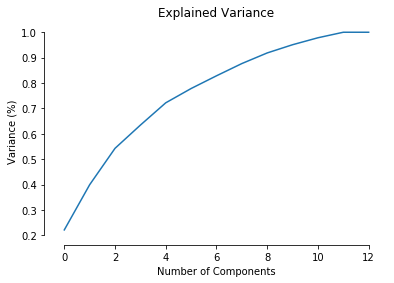

In [30]:
from sklearn.decomposition import PCA
#Fitting the PCA algorithm with our Data
pca = PCA().fit(df)
#Plotting the Cumulative Summation of the Explained Variance
_ = plt.figure()
_ = plt.plot(np.cumsum(pca.explained_variance_ratio_))
_ = plt.xlabel('Number of Components')
_ = plt.ylabel('Variance (%)') #for each component
_ = plt.title('Explained Variance')
_ = sns.despine(offset=5, trim=True)

In [31]:
print (pca.explained_variance_ratio_.cumsum())

[0.2216964  0.39962667 0.54293313 0.63435954 0.72215484 0.77842162
 0.82845886 0.87668461 0.91851672 0.95085876 0.97823674 1.
 1.        ]


In [32]:
pca = PCA(n_components=9)
pca_result = pca.fit_transform(df)

In [33]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')
cluster.fit_predict(pca_result)

array([7, 3, 4, ..., 8, 3, 5])

In [34]:
df['x'] = pca_result[:,0] 
df['y'] = pca_result[:,1]
df['label'] = cluster.labels_

In [35]:
df.groupby('label').sum()

,Action_b,Adventure_b,Crime_b,Documentary_b,Drama_b,Family_b,Fantasy_b,History_b,Horror_b,Music_b,Mystery_b,Romance_b,War_b,x,y
label,,,,,,,,,,,,,,,
0,54.0,7.0,20.0,356.0,495.0,85.0,172.0,340.0,13.0,75.0,27.0,331.0,61.0,-226.286117,201.045470
1,163.0,153.0,31.0,90.0,97.0,54.0,57.0,112.0,28.0,10.0,16.0,0.0,61.0,169.869254,98.055145
2,173.0,101.0,56.0,2.0,229.0,37.0,92.0,12.0,11.0,8.0,19.0,245.0,7.0,-43.792411,31.780724
3,252.0,225.0,10.0,0.0,39.0,97.0,252.0,21.0,76.0,1.0,16.0,2.0,17.0,314.353924,-63.422855
4,93.0,23.0,128.0,21.0,72.0,5.0,17.0,11.0,132.0,8.0,149.0,5.0,0.0,72.511880,158.190508
5,16.0,207.0,5.0,65.0,159.0,313.0,315.0,81.0,125.0,36.0,60.0,50.0,12.0,169.170797,-188.057781
6,0.0,0.0,54.0,3.0,226.0,0.0,115.0,0.0,127.0,3.0,150.0,226.0,0.0,-140.406201,59.894162
7,0.0,0.0,0.0,0.0,297.0,297.0,297.0,0.0,0.0,0.0,0.0,297.0,0.0,-178.981191,-264.627738
8,39.0,0.0,19.0,43.0,197.0,197.0,0.0,0.0,53.0,27.0,15.0,197.0,1.0,-136.439936,-32.857634


In [36]:
df_genres_books[df.label == 8]

,Unnamed: 0,id,title,language_code,description,similar_books,ratings_count,num_pages,text_reviews_count,average_rating,...,Documentary_b,Drama_b,Family_b,Fantasy_b,History_b,Horror_b,Music_b,Mystery_b,Romance_b,War_b
8,14697,26161899,Behind Prison Walls,eng,Behind Prison Walls A True Story of Innocence ...,[],0.0,264.0,1.0,0.00,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
15,45476,28501875,I am Leather-Man,eng,Jake is fed up with his wealthy parents' divor...,[],0.0,149.0,1.0,0.00,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
22,59277,17697218,The Easter Bunny,eng,Jeff has always found comfort in the sense of ...,[],0.0,13.0,1.0,0.00,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
27,67487,36423085,Blow Out the Candles: And Say Goodbye,eng,"Starting over in a new town, Brandy Barrett ho...",[],0.0,352.0,1.0,0.00,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
56,141948,23293790,Views from the Learning Post,eng,Introduction: Becoming a columnist for the Gra...,[],0.0,190.0,1.0,0.00,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
61,154251,18276475,The Keeper of The Darkness [Kindle Edition],eng,Sam has always believed his father died in a t...,[],0.0,171.0,1.0,0.00,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
84,194772,26229039,A Second Life: St. Patrick's of Armagh,eng,About the restoration of the Old Rock Church a...,[],0.0,143.0,1.0,0.00,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
120,276318,17449561,Badlands,eng,A novella about a suburban mother dying at hom...,[],0.0,222.0,1.0,0.00,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
139,318032,29915324,The Nature of the Game,eng,The athletes at Windsor High are aiming for bi...,[],0.0,76.0,1.0,0.00,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
159,349390,36287896,A life span,eng,About the life of Mate Glamuzina. And the embr...,[],0.0,135.0,1.0,0.00,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [151]:
doc1 = df_sample_PoS.description[19]
print(doc1)

"This critical, historical, and theoretical study looks at a little-known group of novels written during the 1930s by women who were literary radicals. Arguing that class consciousness was figured through metaphors of gender, Paula Rabinowitz challenges the conventional wisdom that feminism as a discourse disappeared during the decade. She focuses on the ways in which sexuality and maternity reconstruct the "classic" proletarian novel to speak about both the working-class woman and the radical female intellectual."
--From the book, via Amazon


In [152]:
doc2 = df_sample_PoS.description[39]
print(doc2)

"Michel Faber leads us back to 1870s London, where Sugar, a nineteen-year-old whore in the brothel of the terrifying Mrs. Castaway, yearns for escape into a better life. Her ascent through the strata of Victorian Society offers us intimacy with a host of lovable, maddening, unforgettable characters." They begin with William Rackham, an egotistical perfume magnate whose ambition is fueled by his lust for Sugar, and whose patronage of her brings her into proximity to his extended family and milieu: his unhinged, child-like wife, Agnes; his mysteriously hidden-away daughter, Sophie; and his pious brother Henry, foiled in his devotional calling by a persistently less-than-chaste love for the Widow Fox, whose efforts on behalf of The Rescue Society lead Henry into ever-more disturbing confrontations with flesh.
